# Expression Classification Model Training

This notebook demonstrates how to train a custom expression classification model using TensorFlow and Keras, with CUDA support for GPU acceleration. The model will classify facial expressions into 7 categories: angry, disgust, fear, happy, neutral, sad, and surprise.

## Gpu preperation

In [1]:
# check the GPU
!nvidia-smi

Sat Aug 31 15:29:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    On  | 00000000:82:00.0 Off |                  Off |
| 30%   38C    P8               9W / 130W |      2MiB / 20475MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install tensorflow[and-cuda] Keras NumPy Matplotlib Seaborn Scikit-learn opendatasets

## librarys and dependency calling

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import random
from PIL import Image 

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Device name: ", tf.config.list_physical_devices('GPU'))
print("Build With CUDA: ", tf.test.is_built_with_cuda())
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
Device name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Build With CUDA:  True
TensorFlow version: 2.17.0


## Data Preparation and Normalization

#### dataset download (if not done)

In [21]:
# downloading the dataset
import opendatasets as od
import threading

def download_dataset(url):
    od.download(url, force=True)

# URL for the dataset
url = "https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset"

# Create a thread for downloading the dataset
download_thread = threading.Thread(target=download_dataset, args=(url,))

# Start the download thread
download_thread.start()

# Wait for the download to complete
download_thread.join()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  azzarbudiyanto


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset


100%|██████████| 121M/121M [00:04<00:00, 26.7MB/s] 


KeyboardInterrupt: 

#### data preparation

In [22]:
# Set the path to your main data directory
data_dir = './face-expression-recognition-dataset/images/images'

# Define image parameters
img_height, img_width = 48, 48
batch_size = 150
num_classes = 7

# Create data generators with preprocessing
def preprocess_image(img):
    # Convert to grayscale if the image is RGB
    if img.shape[-1] == 3:
        img = tf.image.rgb_to_grayscale(img)
    # Ensure the image is float32
    img = tf.cast(img, tf.float32)
    # Normalize to [-1, 1]
    img = (img / 127.5) - 1
    return img

# Data generator for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True
)

# Load and prepare the training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

# Data generator for validation data
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

# Load and prepare the validation data
validation_generator = validation_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

# Load and prepare the test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Number of training samples: 28821
Number of validation samples: 7066
Number of test samples: 7066
Number of classes: 7
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


#### balance the data

In [23]:
# Compute class weights to handle imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.031125898894494, 1: 9.443315858453474, 2: 1.0034817729187702, 3: 0.5747188322565207, 4: 0.8264322991340254, 5: 0.8337962159347335, 6: 1.2846445286382884}


## Visualize Some Training Images

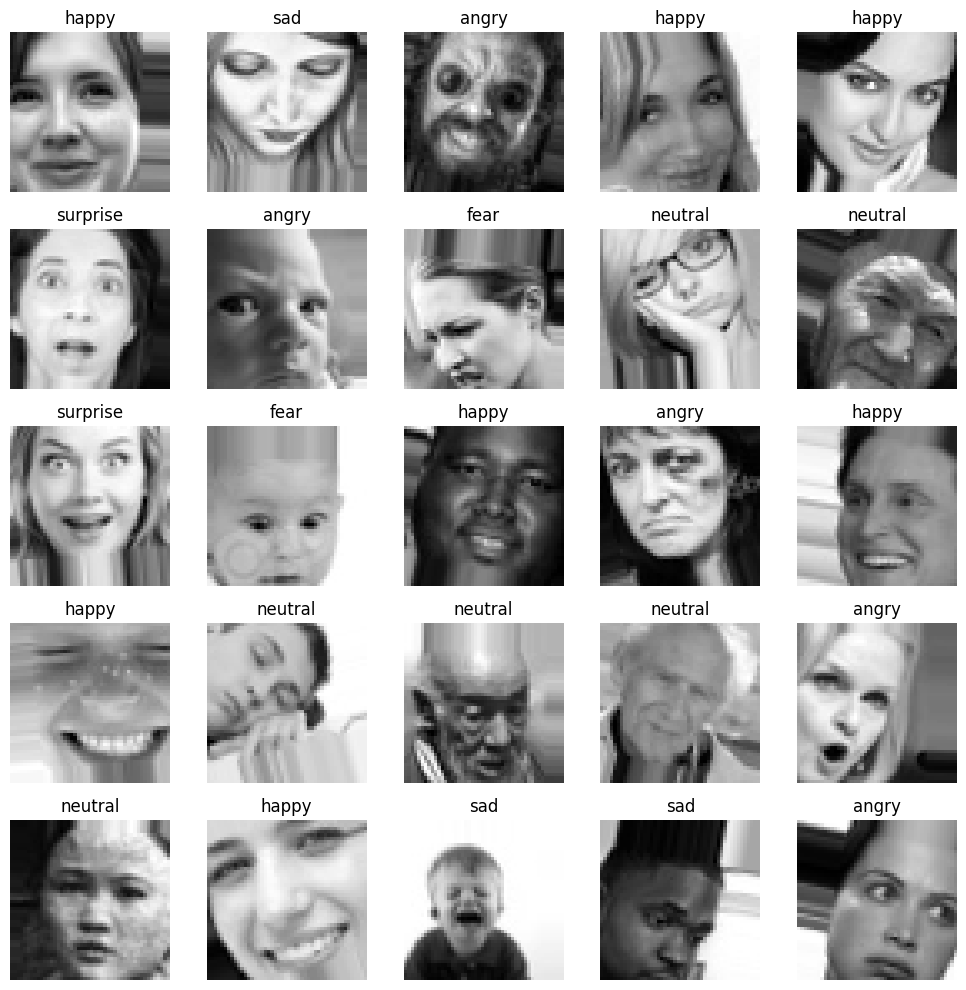

In [24]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n].reshape(img_height, img_width), cmap='gray')
        plt.title(list(train_generator.class_indices.keys())[label_batch[n].argmax()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images and labels
image_batch, label_batch = next(iter(train_generator))

# Visualize the batch
show_batch(image_batch, label_batch)

## Model Definition

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

## Model Training

Check GPU Configuration

In [8]:
# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", tf.config.experimental.get_device_details(physical_devices[0])['device_name'])
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU not found. Using CPU.")

Using GPU: NVIDIA RTX 4000 Ada Generation


RuntimeError: Physical devices cannot be modified after being initialized

callback

In [9]:
# Compile the model with the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('img_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Weight calculation

In [10]:
# Calculate the class weights
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary format required by TensorFlow
class_weight_dict = dict(enumerate(class_weight))

Model training

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/100


/opt/micromamba/envs/python_310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725118303.423654    4236 service.cc:146] XLA service 0x7f9e84005930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725118303.423702    4236 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2024-08-31 15:31:43.496694: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-31 15:31:43.697306: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 890

  1/192 ━━━━━━━━━━━━━━━━━━━━ 33:16 10s/step - accuracy: 0.1133 - loss: 1.7938

I0000 00:00:1725118305.888880    4236 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 34/192 ━━━━━━━━━━━━━━━━━━━━ 2:11 835ms/step - accuracy: 0.1494 - loss: 1.9273

E0000 00:00:1725118335.078165    4237 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725118335.209971    4237 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725118335.368247    4237 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


101/192 ━━━━━━━━━━━━━━━━━━━━ 1:21 898ms/step - accuracy: 0.1661 - loss: 1.9201

KeyboardInterrupt: 

Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

## Training Results Visualization

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Confusion Matrix

In [ ]:
# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys())))

## Try Out the Model

In [ ]:
# Define global variables for image dimensions
img_height, img_width = 46, 46

def preprocess_image(img_array):
    # Normalize the image array
    img_array = img_array.astype('float32') / 255.0
    return img_array

def predict_expression(img_path, model, class_names):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_image(img_array)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Make predictions
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]
    confidence = np.max(prediction)

    # Convert the image tensor to a NumPy array for visualization
    img_array_np = img_array.numpy().squeeze()  # Convert to NumPy array and remove dimensions

    # Display the image and prediction
    plt.imshow(img_array_np, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.show()

    # Print probabilities for each class
    print("Probabilities for each class:")
    for class_name, prob in zip(class_names, prediction[0]):
        print(f"{class_name}: {prob:.4f}")

# Example usage:
# Assuming you have loaded your model and class names
model = tf.keras.models.load_model('expression_classification_model.keras')
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
predict_expression('./face-expression-recognition-dataset/images/images/validation/fear/10029.jpg', loaded_model, categories)


## Save the Model

In [ ]:
# Save the entire model as a SavedModel
model.save('expression_classification_model.keras')
print("Model saved as 'expression_classification_model.keras'")

# Save the model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved as 'model_architecture.json'")

# Save the trained weights
model.save_weights("model.weights.h5")
print("Model weights saved as 'model.weights.h5'")

## Load and Use the Saved Model

In [12]:
# Load the saved model
loaded_model = tf.keras.models.load_model('expression_classification_model.keras')

# Verify the model architecture
loaded_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,399 (1.39 MB)

 Trainable params: 121,799 (475.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,600 (951.57 KB)

#### test with selected image

W0000 00:00:1725118551.705035    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.728453    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.728932    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.730092    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.730672    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.731122    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.731540    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.731959    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.732375    4237 gp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


W0000 00:00:1725118551.905988    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.906332    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.906654    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.906974    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.907434    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.907784    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.908132    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.908490    4237 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725118551.908863    4237 gp

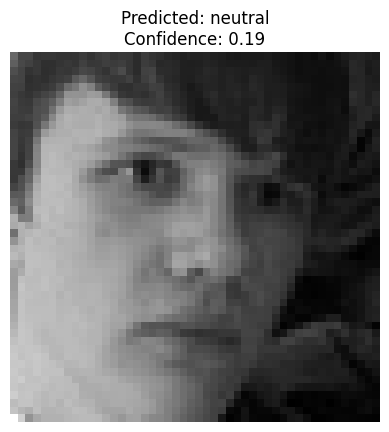

Probabilities for each class:
angry: 0.1162
disgust: 0.1646
fear: 0.1322
happy: 0.1789
neutral: 0.1888
sad: 0.1369
surprise: 0.0824


In [16]:
# Define the category labels
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def predict_expression(image_path, model):
    # Load and preprocess the image
    img = Image.open(image_path).convert('L')  # Convert image to grayscale
    img = img.resize((46, 46))  # Resize to match the model's expected input shape
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize if required

    # Make predictions
    predictions = model.predict(img_array)
    
    # Get the index of the maximum value (predicted class)
    predicted_class_index = np.argmax(predictions[0])
    
    # Map the index to the category label
    predicted_category = categories[predicted_class_index]
    
    # Get the confidence of the prediction
    confidence = predictions[0][predicted_class_index]
    
    # Load the image for display
    img_display = Image.open(image_path)
    
    # Display the image and prediction
    plt.imshow(img_display, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {predicted_category}\nConfidence: {confidence:.2f}")
    plt.show()
    
    # Print the probabilities for each class
    print("Probabilities for each class:")
    for class_name, prob in zip(categories, predictions[0]):
        print(f"{class_name}: {prob:.4f}")

# Example usage:
# Assuming you have loaded your model
model = tf.keras.models.load_model('expression_classification_model.keras')
predict_expression('./face-expression-recognition-dataset/images/images/validation/sad/17666.jpg', loaded_model)


#### test with random image from the validation dataset

Chosen image path: ./face-expression-recognition-dataset/images/images/validation/angry/2933.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


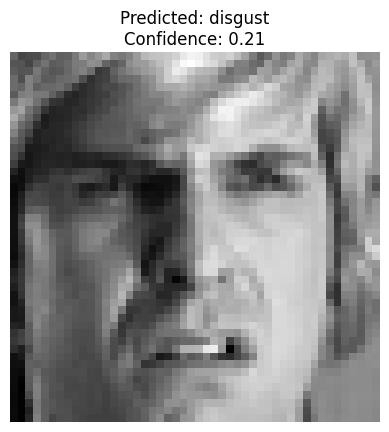

Probabilities for each class:
angry: 0.1355
disgust: 0.2063
fear: 0.1284
happy: 0.1827
neutral: 0.1499
sad: 0.1358
surprise: 0.0614


In [20]:
# Define the category labels
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def predict_expression(image_path, model):
    # Load and preprocess the image
    img = Image.open(image_path).convert('L')  # Convert image to grayscale
    img = img.resize((46, 46))  # Resize to match the model's expected input shape
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize if required

    # Make predictions
    predictions = model.predict(img_array)
    
    # Get the index of the maximum value (predicted class)
    predicted_class_index = np.argmax(predictions[0])
    
    # Get the predicted category
    predicted_category = categories[predicted_class_index]
    
    # Get the confidence of the prediction
    confidence = predictions[0][predicted_class_index]
    
    # Load the image for display
    img_display = Image.open(image_path)
    
    # Display the image and prediction
    plt.imshow(img_display, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {predicted_category}\nConfidence: {confidence:.2f}")
    plt.show()
    
    # Print the probabilities for each class
    print("Probabilities for each class:")
    for class_name, prob in zip(categories, predictions[0]):
        print(f"{class_name}: {prob:.4f}")
    
    return predicted_category, confidence

def get_random_image_path(base_dir):
    # Get all subdirectories (categories)
    categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Choose a random category
    random_category = random.choice(categories)
    
    # Get all image files in the chosen category
    category_path = os.path.join(base_dir, random_category)
    image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
    
    # Choose a random image file
    random_image = random.choice(image_files)
    
    return os.path.join(category_path, random_image)

# Directory containing the images
base_dir = './face-expression-recognition-dataset/images/images/validation/'

# Choose a random image
random_image_path = get_random_image_path(base_dir)

# Print the path of the chosen image
print(f"Chosen image path: {random_image_path}")

# Load the model
# Replace 'expression_classification_model.keras' with your model file path
loaded_model = tf.keras.models.load_model('expression_classification_model.keras')

# Make a prediction
predicted_category, confidence = predict_expression(random_image_path, loaded_model)